In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qmap.toolkit import aligner
COLORS = ['#1C7ED6', '#77DD77', '#FFB347', '#FF6961', '#17BECF', '#F4D35E', "#ADFF2F", "#FF8200"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLORS)

In [3]:
MIN_SEQ_LEN = 1
MAX_SEQ_LEN = 100

In [6]:
def read_fasta(file_path):
    """
    Reads a FASTA file and returns a list of tuples containing sequence IDs and sequences.
    :param file_path: The path to the FASTA file.
    :return:
    """
    with open(file_path, 'r') as f:
        lines = f.readlines()
    sequences = []
    for line in lines:
        if line.startswith('>'):
            id_ = line[1:].strip()
        else:
            sequence = line.strip()
            sequences.append((id_, sequence))
    return sequences

# Load data

In [7]:
dm = np.load(f"../data_leakage/.cache/identity_matrix.npy")
with open(f"../data_leakage/.cache/row_ids.txt", 'r') as f:
    dm_ids = np.array([int(id_) for id_ in f.readlines()])

dataset = read_fasta("../data/build/dataset.fasta")
dataset = {int(id_): seq for id_, seq in dataset}

# Filter like for the other experiments
mask = np.array([MIN_SEQ_LEN <= len(dataset[id_]) <= MAX_SEQ_LEN for id_ in dm_ids])
dm = dm[mask][:, mask]  # Filter the distance matrix
dm_ids = dm_ids[mask]  # Filter the IDs accordingly

In [8]:
# Now, compute the pseudo-distance matrix
data = {key: value for key, value in dataset.items() if MIN_SEQ_LEN <= len(value) <= MAX_SEQ_LEN}
ids, sequences = zip(*data.items())

In [9]:
encoder = aligner.Encoder(force_cpu=True)
vectorDB = encoder.encode(sequences)
alignments = aligner.align_db(vectorDB, vectorDB, device="cpu").alignment_matrix

Encoding sequences:   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━  38/38 it 0.34 it/s eta 00:00


In [10]:
# Now, compare the pseudo-alignments with the true alignments
error = np.abs(alignments - dm)
mean_difference = np.mean(error)
label = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantiles = np.quantile(error, label)
print(f"Mean difference between pseudo-alignments and true alignments: {mean_difference}")
print("Quantiles of the error:")
for q, val in zip(label, quantiles):
    print(f"- {q:.2f} quantile: {val}")

Mean difference between pseudo-alignments and true alignments: 0.04068630262965577
Quantiles of the error:
- 0.05 quantile: 0.0027851305509868363
- 0.10 quantile: 0.005637428977272735
- 0.25 quantile: 0.014599609374999989
- 0.50 quantile: 0.031944861778846145
- 0.75 quantile: 0.05695657169117646
- 0.90 quantile: 0.08641601562500001
- 0.95 quantile: 0.107666015625
- 0.99 quantile: 0.156982421875


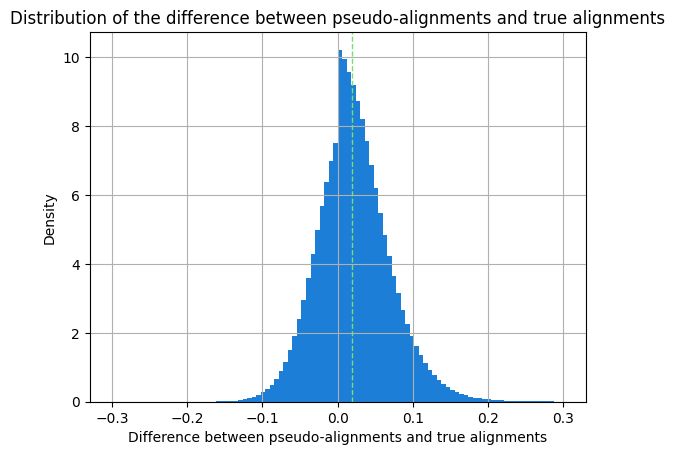

In [11]:
# Plot a figure of the error distribution
flatten_align = alignments.reshape(-1)
flatten_targets = dm.reshape(-1)
error = flatten_align - flatten_targets
# mid_iden_error = error[np.logical_and(flatten_targets > 0.4, flatten_targets < 0.6)]
plt.hist(error, bins=100, density=True, range=(-0.3, 0.3))
# vertical line
plt.axvline(np.median(error), color=COLORS[1], linestyle='dashed', linewidth=1)
plt.xlabel("Difference between pseudo-alignments and true alignments")
plt.ylabel("Density")
plt.title("Distribution of the difference between pseudo-alignments and true alignments")
plt.grid()